# INSEE income data - User validation 

In [1]:
import twitter_profile_predictor as tpp

import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import ast

ModuleNotFoundError: No module named 'twitter_profile_predictor'

### Using Tim's data

In [3]:
# # Load the data

# path = '/home/livtollanes/NewData/coordinates/dim_X/'
# file = '/m1_dimx_users_bios.csv'
# m1_bios = pd.read_csv(path+file, index_col=0)


# If the job titles have already been collected
path = '/home/livtollanes/NewData/professions/'
file = 'm1_professions.csv'
m1_bios = pd.read_csv(path+file, index_col=0)


In [9]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
m1_bios[['projection', 'screen_name', 'description_cleantext']].tail(80)

,projection,screen_name,description_cleantext
114999,-2.374537,vsylvestre85,"J ai 15 ans collegien, au college Jean Deconinck"
115000,-2.374537,DiafFarid,Mes tweets n'engagent que moi!
115001,-2.374537,e_lemeur01,Je parle de vélo et de mon FC Lorient
115002,-2.377410,FrMstk_aurelM,supporter du fcsm ps4 cod
115003,-2.379934,Districtfoot37,Compte officiel du District d'Indre-et-Loire de football (37)
115004,-2.380722,PierrotDLT,"Le jour où les cons voleront, tu seras chef d'escadrille."
115005,-2.381205,RooohMain,"PSG, Tenons nous unis PSG, Ici c'est ParisTous ensemble le coeur a jamaisRouge & Bleu Pour le PSG"
115006,-2.382454,Twittofoot,En direct du canapé !
115007,-2.382608,VTransler,Compte officiel de l'entraîneur Valentin TranslerBEF Coach U18 R1Responsable U11UF Mâconnais
115008,-2.385056,AnOriantDaViken,Twitter du groupe An Oriant Da Viken de Facebook groupe de supporter du FC Lorient


In [4]:
#analyser = tpp.df_bios_analyzer(m1_bios, description_column= 'description_cleantext')
#analyser.get_all(mainfrench='True')
#analyser.get_PCSgroup()


analyser = tpp.df_bios_analyzer(m1_bios, description_column= 'description_cleantext')
analyser.get_prostatus()

# #write to csv to avoid rerunning every time
# m1_bios.to_csv('/home/livtollanes/NewData/professions/m1_professions.csv')

In [7]:
#Select only rows where professions is not an empty list
m1_bios_professions = m1_bios[m1_bios['professions'].apply(lambda x: x != "[]")] #removing 87 183 rows

m1_bios_professions.shape #27896
#m1_bios.shape #115 079

(27896, 21)

In [26]:
#Filter the DataFrame to only include the users with one title only
m1_single_jobs = m1_bios_professions.loc[m1_bios_professions['professions'].apply(lambda x: len(ast.literal_eval(x)) == 1)]

#Make the format normal style
m1_single_jobs['professions'] = m1_single_jobs['professions'].apply(lambda x: ast.literal_eval(x)[0])
m1_single_jobs['PCSgroup'] = m1_single_jobs['PCSgroup'].apply(lambda x: ast.literal_eval(x)[0])


/tmp/ipykernel_2903710/2755774420.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m1_single_jobs['professions'] = m1_single_jobs['professions'].apply(lambda x: ast.literal_eval(x)[0])
/tmp/ipykernel_2903710/2755774420.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m1_single_jobs['PCSgroup'] = m1_single_jobs['PCSgroup'].apply(lambda x: ast.literal_eval(x)[0])


In [40]:
#Inspection of specifc job  titles/columns
col = 'blogger'  # replace with the value you're interested in
m1_single_jobs.loc[m1_single_jobs['professions'].apply(lambda x: x == col)].iloc[:, 4:].head()

,projection,screen_name,description_cleantext,tokens,bi_tokens,full_tokens,professions,prostatus,actorstatus,groupstatus,universitystatus,allstatus,age,gender,topic,lang,PCSgroup
217,1.791862,LnArnal,Blogueuse de sciences @Sciences_Cinema et vidéaste derrière @SGeantes et sur @LnArnal@piaille.fr,"['blogueuse', 'sciences', 'sciencescinema', 'vidéaste', 'derrière', 'sgeantes', 'lnarnalpiaillefr']","[('blogueuse', 'sciences'), ('sciences', 'sciencescinema'), ('sciencescinema', 'vidéaste'), ('vidéaste', 'derrière'), ('derrière', 'sgeantes'), ('sgeantes', 'lnarnalpiaillefr')]","['blogueuse', 'sciences', 'sciencescinema', 'vidéaste', 'derrière', 'sgeantes', 'lnarnalpiaillefr', ('blogueuse', 'sciences'), ('sciences', 'sciencescinema'), ('sciencescinema', 'vidéaste'), ('vidéaste', 'derrière'), ('derrière', 'sgeantes'), ('sgeantes', 'lnarnalpiaillefr')]",blogger,[],[],[],[],[],[],['Woman'],['sciences'],fr,"Information, arts and entertainment professions"
1289,1.576307,B_fournier,Directeur associé Duneconsulting - Directeur stratégie et développement Theteamschool #blogueuse #Communication #Branding #Conseil #Ens sup #France #Espagne,"['directeur', 'associé', 'duneconsulting', 'directeur', 'stratégie', 'développement', 'theteamschool', 'blogueuse', 'communication', 'branding', 'conseil', 'ens', 'sup', 'france', 'espagne']","[('directeur', 'associé'), ('associé', 'duneconsulting'), ('duneconsulting', 'directeur'), ('directeur', 'stratégie'), ('stratégie', 'développement'), ('développement', 'theteamschool'), ('theteamschool', 'blogueuse'), ('blogueuse', 'communication'), ('communication', 'branding'), ('branding', 'conseil'), ('conseil', 'ens'), ('ens', 'sup'), ('sup', 'france'), ('france', 'espagne')]","['directeur', 'associé', 'duneconsulting', 'directeur', 'stratégie', 'développement', 'theteamschool', 'blogueuse', 'communication', 'branding', 'conseil', 'ens', 'sup', 'france', 'espagne', ('directeur', 'associé'), ('associé', 'duneconsulting'), ('duneconsulting', 'directeur'), ('directeur', 'stratégie'), ('stratégie', 'développement'), ('développement', 'theteamschool'), ('theteamschool', 'blogueuse'), ('blogueuse', 'communication'), ('communication', 'branding'), ('branding', 'conseil'), ('conseil', 'ens'), ('ens', 'sup'), ('sup', 'france'), ('france', 'espagne')]",blogger,[director],[],[],[],"['deputy director', 'director']",[],['Woman'],"['strategy', 'development', 'communication']",fr,"Information, arts and entertainment professions"
1523,1.536624,CHERAZOU,#digitalmum #culture #art #éducation #banque #finance #DigitalBanking #bddf #RSE #CM #blogueuse #RédactriceWeb #entreprenariat #teamentrepreneur #i4EmploiR,"['digitalmum', 'culture', 'art', 'éducation', 'banque', 'finance', 'digitalbanking', 'bddf', 'rse', 'cm', 'blogueuse', 'rédactriceweb', 'entreprenariat', 'teamentrepreneur', 'i4emploir']","[('digitalmum', 'culture'), ('culture', 'art'), ('art', 'éducation'), ('éducation', 'banque'), ('banque', 'finance'), ('finance', 'digitalbanking'), ('digitalbanking', 'bddf'), ('bddf', 'rse'), ('rse', 'cm'), ('cm', 'blogueuse'), ('blogueuse', 'rédactriceweb'), ('rédactriceweb', 'entreprenariat'), ('entreprenariat', 'teamentrepreneur'), ('teamentrepreneur', 'i4emploir')]","['digitalmum', 'culture', 'art', 'éducation', 'banque', 'finance', 'digitalbanking', 'bddf', 'rse', 'cm', 'blogueuse', 'rédactriceweb', 'entreprenariat', 'teamentrepreneur', 'i4emploir', ('digitalmum', 'culture'), ('culture', 'art'), ('art', 'éducation'), ('éducation', 'banque'), ('banque', 'finance'), ('finance', 'digitalbanking'), ('digitalbanking', 'bddf'), ('bddf', 'rse'), ('rse', 'cm'), ('cm', 'blogueuse'), ('blogueuse', 'rédactriceweb'), ('rédactriceweb', 'entreprenariat'), ('entreprenariat', 'teamentrepreneur'), ('teamentrepreneur', 'i4emploir')]",blogger,[],[],[],[],[],[],['Woman'],"['education', 'finance', 'culture']",fr,"Information, arts and entertainment professions"
6644,0.907052,Twitizel,Blogueur élevé en plein air depuis 2004...,"['blogueur', 'élevé', 'ple

In [52]:
m1_single_jobs['professions'].unique #we have 51 unique, single job titles 

<bound method Series.unique of 9                                ['ceo']
12                   ['human resources']
17                   ['human resources']
26                          ['engineer']
46                        ['researcher']
50                           ['analyst']
57            ['communications manager']
78            ['communications manager']
82                        ['consultant']
83                         ['professor']
87                 ['community manager']
97            ['communications manager']
102                  ['human resources']
104                  ['project manager']
107                  ['mission manager']
108                       ['accountant']
114                            ['actor']
115                  ['human resources']
119                  ['human resources']
122                            ['actor']
125                  ['human resources']
133                       ['consultant']
137                  ['mission manager']
139                       

#Income test

In [80]:
#load income data
path = '/home/livtollanes/10.jan-thesis/labeldata/'
file = 'grov_rett.csv'
dtypes = {'income_mois': 'float'}
income = pd.read_csv(path+file, sep=',', dtype=dtypes)

income = income.rename(columns={'data_job_titles': 'professions'})

income['income_mois'] = income['income_mois'].dropna()

income_bios = income_bios = pd.merge(m1_single_jobs, income[['professions', 'income_mois']], on='professions', how='left')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


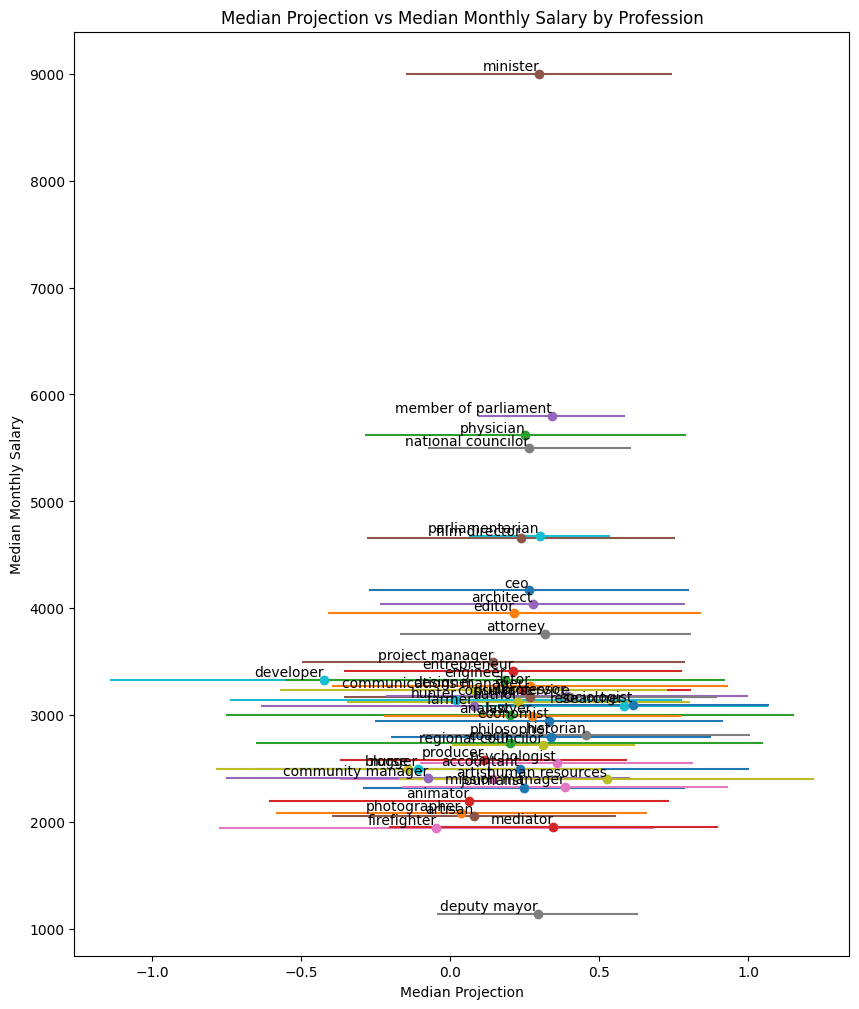

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the median of 'projection', its standard deviation, and median of 'income_mois' for each job group
grouped = income_bios.groupby('professions').agg({'projection': ['median', 'std'], 'income_mois': 'median'}).reset_index()

# Sort the jobs by median projection
grouped = grouped.sort_values(('projection', 'median'))

plt.figure(figsize=(10, 12))  # Increase the height of the figure

# Plot error bars for each job with a small random jitter added to the y-coordinates
for i in range(grouped.shape[0]):
    jitter = np.random.uniform(-0.3, 0.3)  # adjust the range as needed
    plt.errorbar(x=grouped[('projection', 'median')][i], 
                 y=grouped[('income_mois', 'median')][i] + jitter, 
                 xerr=grouped[('projection', 'std')][i], 
                 fmt='o')

# Add job labels to each point
for i in range(grouped.shape[0]):
    plt.text(grouped[('projection', 'median')][i], 
             grouped[('income_mois', 'median')][i], 
             grouped['professions'][i], 
             ha = 'right', va = 'bottom')

plt.xlabel('Median Projection')
plt.ylabel('Median Monthly Salary')
plt.title('Median Projection vs Median Monthly Salary by Profession')
plt.show()

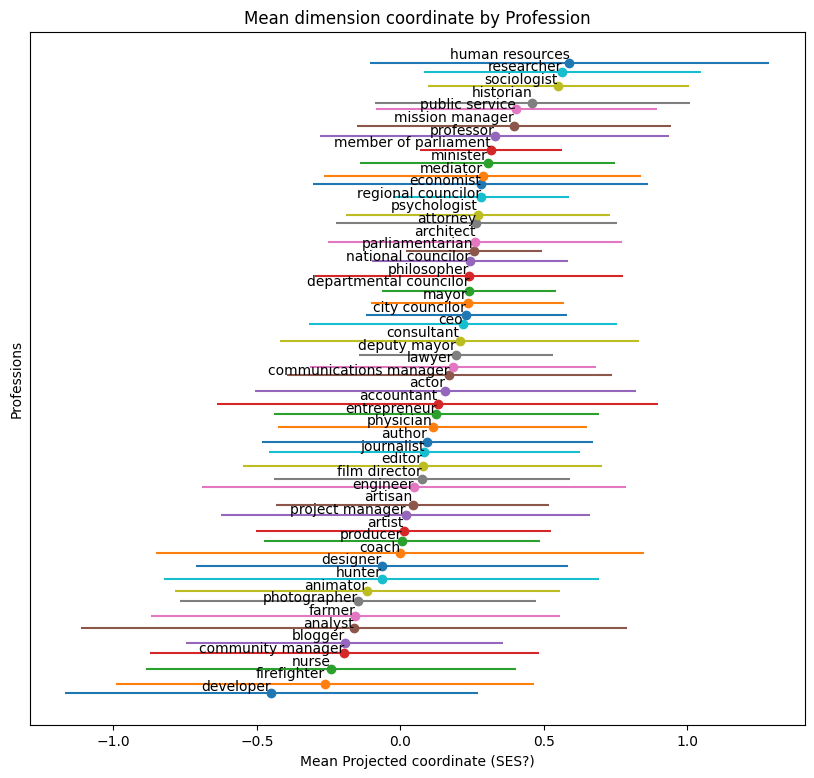

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean of 'projection' and its standard deviation for each job group
grouped = income_bios.groupby('professions').agg({'projection': ['mean', 'std']}).reset_index()

# Sort the jobs by mean projection and reset index
grouped = grouped.sort_values(('projection', 'mean')).reset_index(drop=True)
plt.figure(figsize=(10, 9))  # Adjust the size of the figure

# Plot error bars for each job with a small random jitter added to the y-coordinates
for i in range(grouped.shape[0]):
    jitter = np.random.uniform(-0.3, 0.3)  # adjust the range as needed
    plt.errorbar(x=grouped[('projection', 'mean')][i], 
                 y=i + jitter, 
                 xerr=grouped[('projection', 'std')][i], 
                 fmt='o')

# Add job labels to each point
for i in range(grouped.shape[0]):
    plt.text(grouped[('projection', 'mean')][i], 
             i, 
             grouped['professions'][i], 
             ha = 'right', va = 'bottom')

plt.xlabel('Mean Projected coordinate (SES?)')
plt.ylabel('Professions')
plt.title('Mean dimension coordinate by Profession')

# Remove y-axis numbers
plt.yticks([])

plt.show()

### New income validation approach

In [1]:
import numpy as np
import os
import matplotlib
import pandas as pd

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
import importlib

import sys
# Local application imports
sys.path.insert(0, '../Utility files')
import utils2
from utils2 import *

In [47]:
# # Load the data

path = '/home/livtollanes/NewData/coordinates/dim_X/'
file = '/m1_dimx_users_bios.csv'
m1_bios = pd.read_csv(path+file, index_col=0)

In [48]:
#Sort the df according to the first dimenion
m1_bios_sorted = m1_bios.sort_values(by='0', ascending=False)
m1_bios_sorted.head()

,follower_id,0,1,2,projection,screen_name,description_cleantext
115078,1056110047,2.373287,1.304695,-2.393023,-2.761358,Skunkinh0,L'humilié c'est le charme d'un homme La timidité c'est le chame d'une femme
115077,785463278977839104,2.341063,1.305582,-2.380031,-2.727126,masterdiete,"le cheat meal le meilleur des reconfort apres une semaine de diete strict .je vais tenter de creer un vaste choix de pizza fole,unique et delicieuse"
115076,1251551779,2.309714,1.263744,-2.292223,-2.679998,Oxygene_tango,WebRadio officielle du @stadelavallois // http://www.stade-lavallois.com/o-fm-tango // 90.1 FM à Laval // http://rhasl.creacast.com sur smartphone // #OxygeneTango
115075,1430233254016307200,2.301663,1.264603,-2.292688,-2.672192,JulieDfco21,Fan du rc Lens et du Dfco CM: @100_DFCO_NEWS
115074,3503654182,2.276890,1.233403,-2.291264,-2.649039,SportsValeurs,Partageons les bonnes pratiques du sports ! Suivez nos articles sur http://www.sportsetvaleurs.com/


In [14]:
m1_bios_sorted['follower_id'].nunique() #115079

115079

#### N-gram + frequency analysis

In [19]:
# Concatenate all the descriptions into one string
all_descriptions = ' '.join(m1_bios_sorted['description_cleantext'])

# Remove URLs
all_descriptions = re.sub(r'http\S+|www.\S+', '', all_descriptions)

# Tokenize the string into words
words = word_tokenize(all_descriptions)

# Remove punctuation and convert to lower case
words = [word.lower() for word in words if word.isalpha()]

# Remove French stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))
words = [word for word in words if word not in stop_words]

# Create bigrams
unigrams = ngrams(words, 1)
bigrams = ngrams(words, 2)
trigrams = ngrams(words, 3)

# Count the frequency of each bigram
unigram_freq = Counter(unigrams)
bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

# Get the most common bigrams
most_common_unigrams = unigram_freq.most_common(4000)
# most_common_bigrams = bigram_freq.most_common(2000)
# most_common_trigrams = trigram_freq.most_common(2000)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/livtollanes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
# importlib.reload(utils2)
# utils2.write_ngrams_to_csv(most_common_unigrams, 'unigrams.csv')
# utils2.write_ngrams_to_csv(most_common_bigrams, 'bigrams.csv')
# utils2.write_ngrams_to_csv(most_common_trigrams, 'trigrams.csv')
# utils2.write_ngrams_to_csv(unigrams_last1000, 'uni_last1000.csv')

In [49]:
#Load the final N-gram file
path = '/home/livtollanes/10.jan-thesis/Code/Brand Validation/'
file = 'N_grams_INSEE.csv'
n_grams = pd.read_csv(path+file, header=1)

In [34]:
pd.set_option('display.max_colwidth', None)
filtered_m1_bios[['screen_name', '0', 'description_cleantext', 'detected_ngrams']].iloc[0:10]

,screen_name,0,description_cleantext,detected_ngrams
6,g_lechevallier,-1.847305,"Directeur d'Unité @mc2iGroupe, #Conseil en Système d'Information et organisation (#SI). Sponsor de l'offre sectorielle #Transport.",[directeur]
8,degust_harmonie,-1.847305,"Consultant, formateur et animateur en oenologiechez Dégustation et Harmonie""Mieux analyser le vin pour laisser parler vos émotions""","[consultant, animateur, formateur]"
9,MelvynBoukli,-1.847305,Directeur Général (CEO) de @EasywaFR contact pro : melvyn@easywa.fr,"[directeur, directeur général]"
11,Integrerlx,-1.847305,Méthodes et astuces en prépa scientifique pour réussir les concours des plus prestigieuses écoles d'ingénieurs.,[ingénieur]
13,tekkitIo,-1.821927,"#Tekkit est le premier #RéseauSocial professionnel pour les métiers de la #Tech, de l'#IT et de l'#Ingénierie. Rejoignez la communauté : https://tekkit.io/",[prof]
16,PontsAlumni,-1.805492,"Association des #diplômés de @EcoleDesPonts, école d'ingénieurs depuis 1747 !#réseau #animation #carrière",[ingénieur]
20,oddiris,-1.775111,Site de #recrutement par affinités professionnelles pour les #ingénieurs,"[ingénieur, prof]"
22,CadresDirigeant,-1.747349,"#Cadre & #Dirigeant Magazine, le #site d’info indépendant et collaboratif pour #trouver un emploi, #réussir, #recruter un cadre, #manager et #entreprendre.","[manager, indépendant, cadre, dirigeant]"
25,ESSCA_startup,-1.753937,Compte officiel de la Majeure #Entrepreneurship de l'@ESSCA_Ecole dirigée par @xavier_lesage. #Entreprendre #Entrepreneuriat #SKyourLife,"[entrepreneur, entrepreneuriat]"
26,upstifr,-1.799371,Union des Professeurs de Sciences et Techniques Industrielles. 700 profs de Sciences de l’Ingénieur & Informatique notamment en classe prépa scientifiques.,"[professeur, ingénieur, prof]"


In [35]:
filtered_m1_bios.shape

(49794, 8)

In [50]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk
import re
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

def process_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Tokenize the string into words
    words = word_tokenize(text)
    # Remove punctuation and convert to lower case
    words = [word.lower() for word in words if word.isalpha()]
    # Remove French stopwords
    words = [word for word in words if word not in stop_words]
    return words

def get_ngrams(words, n):
    # Create ngrams
    ngram_list = list(ngrams(words, n))
    return ngram_list

m1_bios_sorted['description_cleantext_tokens'] = m1_bios_sorted['description_cleantext'].apply(process_text)

# Apply the get_ngrams function for n=1, 2, 3
for n in range(1, 4):
    m1_bios_sorted[f'ngrams_{n}'] = m1_bios_sorted['description_cleantext_tokens'].apply(lambda x: get_ngrams(x, n))

# Combine the ngrams
m1_bios_sorted['n_grams'] = m1_bios_sorted[['ngrams_1', 'ngrams_2', 'ngrams_3']].apply(lambda x: x[0] + x[1] + x[2], axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/livtollanes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_3064307/3848661789.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m1_bios_sorted['n_grams'] = m1_bios_sorted[['ngrams_1', 'ngrams_2', 'ngrams_3']].apply(lambda x: x[0] + x[1] + x[2], axis=1)


In [66]:
# Convert n-grams from strings to tuples
n_grams['n_gram'] = n_grams['n_gram'].apply(lambda x: tuple(x.split()))


In [72]:
n_grams.iloc[200:210]

,n_gram,count,ngram,insee_match
200,"(avocate,)",171.0,1.0,NaN
201,"(musicien,)",169.0,1.0,NaN
202,"(députée,)",160.0,1.0,NaN
203,"(dirigeant,)",161.0,1.0,NaN
204,"(conseiller, municipal)",569.0,2.0,NaN
205,"(rédacteur, chef)",340.0,2.0,NaN
206,"(chargée, communication)",334.0,2.0,NaN
207,"(chef, projet)",309.0,2.0,NaN
208,"(responsable, communication)",283.0,2.0,NaN
209,"(conseillère, municipale)",255.0,2.0,NaN


In [69]:
m1_bios_sorted.iloc[200:210]

,follower_id,0,1,2,projection,screen_name,description_cleantext,description_cleantext_tokens,ngrams_1,ngrams_2,ngrams_3,n_grams
114825,940639744056315908,2.025513,1.011498,-1.821962,-2.315179,sondagesport_FR,Des sondages en rapport avec le sport,"[sondages, rapport, sport]","[(sondages,), (rapport,), (sport,)]","[(sondages, rapport), (rapport, sport)]","[(sondages, rapport, sport)]","[(sondages,), (rapport,), (sport,), (sondages, rapport), (rapport, sport), (sondages, rapport, sport)]"
114824,1454821504189882368,2.025513,1.011498,-1.821962,-2.315179,TeamJustinTFC,Toute l'actualité de Justin LACOMBE Gardien au @ToulouseFCIG@justin_lcmb,"[toute, justin, lacombe, gardien, toulousefcig]","[(toute,), (justin,), (lacombe,), (gardien,), (toulousefcig,)]","[(toute, justin), (justin, lacombe), (lacombe, gardien), (gardien, toulousefcig)]","[(toute, justin, lacombe), (justin, lacombe, gardien), (lacombe, gardien, toulousefcig)]","[(toute,), (justin,), (lacombe,), (gardien,), (toulousefcig,), (toute, justin), (justin, lacombe), (lacombe, gardien), (gardien, toulousefcig), (toute, justin, lacombe), (justin, lacombe, gardien), (lacombe, gardien, toulousefcig)]"
114823,546892980,2.025513,1.011498,-1.821962,-2.315179,RyanBrossault,"22 ansMembre de CHAOS""J'ai l'aim à JP""fan du grand @JeanPormanovemais surtout grand fan de @SonyaDevilleWWE & de @ibushi_kota @Coqtolito 4 LIFEallez l'OM","[ansmembre, chaos, jp, fan, grand, jeanpormanovemais, surtout, grand, fan, sonyadevillewwe, coqtolito, lifeallez]","[(ansmembre,), (chaos,), (jp,), (fan,), (grand,), (jeanpormanovemais,), (surtout,), (grand,), (fan,), (sonyadevillewwe,), (coqtolito,), (lifeallez,)]","[(ansmembre, chaos), (chaos, jp), (jp, fan), (fan, grand), (grand, jeanpormanovemais), (jeanpormanovemais, surtout), (surtout, grand), (grand, fan), (fan, sonyadevillewwe), (sonyadevillewwe, coqtolito), (coqtolito, lifeallez)]","[(ansmembre, chaos, jp), (chaos, jp, fan), (jp, fan, grand), (fan, grand, jeanpormanovemais), (grand, jeanpormanovemais, surtout), (jeanpormanovemais, surtout, grand), (surtout, grand, fan), (grand, fan, sonyadevillewwe), (fan, sonyadevillewwe, coqtolito), (sonyadevillewwe, coqtolito, lifeallez)]","[(ansmembre,), (chaos,), (jp,), (fan,), (grand,), (jeanpormanovemais,), (surtout,), (grand,), (fan,), (sonyadevillewwe,), (coqtolito,), (lifeallez,), (ansmembre, chaos), (chaos, jp), (jp, fan), (fan, grand), (grand, jeanpormanovemais), (jeanpormanovemais, surtout), (surtout, grand), (grand, fan), (fan, sonyadevillewwe), (sonyadevillewwe, coqtolito), (coqtolito, lifeallez), (ansmembre, chaos, jp), (chaos, jp, fan), (jp, fan, grand), (fan, grand, jeanpormanovemais), (grand, jeanpormanovemais, surtout), (jeanpormanovemais, surtout, grand), (surtout, grand, fan), (grand, fan, sonyadevillewwe), (fan, sonyadevillewwe, coqtolito), (sonyadevillewwe, coqtolito, lifeallez)]"
114826,868075333353955328,2.025513,1.011498,-1.821962,-2.315179,MercaFoot_,"Bienvenue sur MercaFoot, le média du peuple ! Nous contacter : mercafootpartnerships@gmail.com","[bienvenue, mercafoot, média, peuple, contacter, mercafootpartnerships]","[(bienvenue,), (mercafoot,), (média,), (peuple,), (contacter,), (mercafootpartnerships,)]","[(bienvenue, mercafoot), (mercafoot, média), (média, peuple), (peuple, contacter), (contacter, mercafootpartnerships)]","[(bienvenue, mercafoot, média), (mercafoot, média, peuple), (média, peuple, contacter), (peuple, contacter, mercafootpartnerships)]","[(bienvenue,), (mercafoot,), (média,), (peuple,), (contacter,), (mercafootpartnerships,), (bienvenue, mercafoot), (mercafoot, média), (média, peuple), (peuple, contacter), (contacter, mercafootpartnerships), (bienvenue, mercafoot, média), (mercafoot, média, peuple), (média, peuple, contacter), (peuple, contacter, mercafootpartnerships)]"
114830,2659152601,2.025513,1.011498,-1.821962,-2.315179,GuiJahier,Préparateur Physique au @RCSA,"[préparateur, physique, rcsa]","[(préparateur,), (physique,), (rcsa,)]","[(préparateur, physique), (phy

In [75]:
# Get the list of n-grams from the n_grams DataFrame
ngram_list = n_grams['n_gram'].tolist()

# Filter the m1_bios_sorted DataFrame
filtered_m1_bios_sorted_test = m1_bios_sorted[m1_bios_sorted['n_grams'].apply(lambda x: any(ng in x for ng in ngram_list))]

# Add a new column 'n_grams_detected'
filtered_m1_bios_sorted_test['n_grams_detected'] = filtered_m1_bios_sorted_test['n_grams'].apply(lambda x: [ng for ng in ngram_list if ng in x])

/tmp/ipykernel_3064307/3935704693.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_m1_bios_sorted_test['n_grams_detected'] = filtered_m1_bios_sorted_test['n_grams'].apply(lambda x: [ng for ng in ngram_list if ng in x])


In [82]:
filtered_m1_bios_sorted_test[['0', 'screen_name', 'description_cleantext', 'n_grams', 'n_grams_detected']].head(20)

,0,screen_name,description_cleantext,n_grams,n_grams_detected
115069,2.195024,MijeAssociation,Expert du #voyagescolaire et de l’hébergement à #Paris #mijemarais. L'association #MIJE accompagne le corps #enseignant depuis plus de 60 ans.,"[(expert,), (voyagescolaire,), (hébergement,), (paris,), (mijemarais,), (mije,), (accompagne,), (corps,), (enseignant,), (depuis,), (plus,), (ans,), (expert, voyagescolaire), (voyagescolaire, hébergement), (hébergement, paris), (paris, mijemarais), (mijemarais, mije), (mije, accompagne), (accompagne, corps), (corps, enseignant), (enseignant, depuis), (depuis, plus), (plus, ans), (expert, voyagescolaire, hébergement), (voyagescolaire, hébergement, paris), (hébergement, paris, mijemarais), (paris, mijemarais, mije), (mijemarais, mije, accompagne), (mije, accompagne, corps), (accompagne, corps, enseignant), (corps, enseignant, depuis), (enseignant, depuis, plus), (depuis, plus, ans)]","[(expert,), (enseignant,)]"
115066,2.183514,bone_avocat,Avocat associé Moyersoen Avocats /droit du sport membre fondateur de l'AIAF & l'Association des Avocats en Droit du Sport # AADS,"[(avocat,), (associé,), (moyersoen,), (avocats,), (sport,), (membre,), (fondateur,), (avocats,), (droit,), (sport,), (aads,), (avocat, associé), (associé, moyersoen), (moyersoen, avocats), (avocats, sport), (sport, membre), (membre, fondateur), (fondateur, avocats), (avocats, droit), (droit, sport), (sport, aads), (avocat, associé, moyersoen), (associé, moyersoen, avocats), (moyersoen, avocats, sport), (avocats, sport, membre), (sport, membre, fondateur), (membre, fondateur, avocats), (fondateur, avocats, droit), (avocats, droit, sport), (droit, sport, aads)]","[(fondateur,), (avocat,), (membre, fondateur), (avocat, associé)]"
115067,2.180392,BerenGMARTINEZ,Dirigeant @lafabdusportPassionné de #Sports et de techniques #commerciale Président @DCFdromeardecheMembre du Board @SportConnectLyon,"[(dirigeant,), (lafabdusportpassionné,), (sports,), (techniques,), (commerciale,), (président,), (dcfdromeardechemembre,), (board,), (sportconnectlyon,), (dirigeant, lafabdusportpassionné), (lafabdusportpassionné, sports), (sports, techniques), (techniques, commerciale), (commerciale, président), (président, dcfdromeardechemembre), (dcfdromeardechemembre, board), (board, sportconnectlyon), (dirigeant, lafabdusportpassionné, sports), (lafabdusportpassionné, sports, techniques), (sports, techniques, commerciale), (techniques, commerciale, président), (commerciale, président, dcfdromeardechemembre), (président, dcfdromeardechemembre, board), (dcfdromeardechemembre, board, sportconnectlyon)]","[(président,), (dirigeant,)]"
115065,2.174685,polary_nuno,Grand coach de Pelsea n69 comme les baufs Je suis hétérosexuels pour les meufs hein #PessiNunoLeGoat,"[(grand,), (coach,), (pelsea,), (comme,), (baufs,), (hétérosexuels,), (meufs,), (hein,), (pessinunolegoat,), (grand, coach), (coach, pelsea), (pelsea, comme), (comme, baufs), (baufs, hétérosexuels), (hétérosexuels, meufs), (meufs, hein), (hein, pessinunolegoat), (grand, coach, pelsea), (coach, pelsea, comme), (pelsea, comme, baufs), (comme, baufs, hétérosexuels), (baufs, hétérosexuels, meufs), (hétérosexuels, meufs, hein), (meufs, hein, pessinunolegoat)]","[(coach,)]"
115041,2.141388,Son_and_graf,"Graphiste freelance de métier, j'ai décidé de mettre à mon panel de créations le design de kit sportif afin de vous les partager ici","[(graphiste,), (freelance,), (métier,), (décidé,), (mettre,), (panel,), (créations,), (design,), (kit,), (sportif,), (afin,), (partager,), (ici,), (graphiste, freelance), (freelance, métier), (métier, décidé), (décidé, mettre), (mettre, panel), (panel, créations), (créations, design), (design, kit), (kit, sportif), (sportif, afin), (afin, partager), (partager, ici), (graphiste, freelance, métier), (freelance, métier, décidé), (métier, décidé, mettre), (décidé, mettre, panel), (mettre, panel, créations), (panel, créations, design), (créations, design, kit), (design, kit, sportif),

In [83]:
filtered_m1_bios_sorted_test.shape #40890 detected so far



(40890, 13)

#### 3. Manual inspection

In [51]:
m1_bios_sorted.shape

(115079, 7)

In [50]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
m1_bios_sorted[['description_cleantext','follower_id', 'screen_name']].iloc[-100:-50]

,description_cleantext,follower_id,screen_name
146,Tiers-lieu #CulturesNumériques @citedessciences #FabLab #MouvementMaker #InnovationParticipative #LivingLab #LogicielLibre #GreenIT #JeuVideo #RéalitéVirtuelle,271974188,CarrNum
68,Fil d'actualités du Lycée Paul Langevin de Suresnes,1094232659499327488,LangevinLycee
73,Novasys Ingénierie est une société créée en 2007 et rattachée au Groupe Pacte Novation. Le logiciel temps réel embarqué est au coeur de notre activité.,731093463144484864,NovasysInge
71,Juniors & Seniors ! Démontrez vos compétences et entraidez-vous pour trouver un emploi.,2583532274,eJobSkills
107,"Chargé de mission E-Learning à l'Ecole polytechnique Intéressé par E-Learning, Mooc, Pédagogie, TIC",1846740931,E_Vantroeyen
116,Conférence des directeurs des écoles françaises d'#ingénieurs,38402886,Cdefi
129,La Section Jeunes de la Société Géologique de France promeut et organise des activités pour les jeunes scientifiques des géosciences.,113321123,SGF_J
80,AGC propose une solution alternative au statut de travailleur indépendant : Le portage salarial .,1430474888,AGCportage
114,"Acteur majeur des projets industriels, ASYMPTOTE Project Management met à votre disposition toutes ses compétences et son savoir-faire en Gestion de Projet.",2598044293,asymptote_pm
97,Chargée de communication direction du patrimoine à l'Université Paris-Sud @u_psud #UPSud #ParisSaclay #TeamUPSaclay #communication #web,1965038047,MarieBeuneu
